In [140]:
from typing import List, Tuple, Optional, Mapping
import pandas as pd
import numpy as np
from collections import defaultdict
import statsmodels.api as sm
import pickle

In [609]:
class IndicesSelector():
    def __init__(self):
        pass

    def select(self, df: Optional[pd.DataFrame] = None) -> List[str]:
        price_df = pd.read_csv('price_df.csv')
        return price_df['ETF_Ticker'].unique()

In [610]:
class PairsSelector():
    def __init__(self):
        pass

    def select(self, df: Optional[pd.DataFrame] = None) -> List[List[str]]:
        training_df = pd.read_csv('TrainingSet.csv')
        pairs = [[p.split("_")[0], p.split("_")[1]] for p in training_df["Ticker_Pair"].unique()]
        return pairs

In [611]:
class Predictor():
    def __init__(self):
        pass
    
    def train(self, data: Optional[pd.DataFrame] = None, params: Optional[Mapping] = None):
        pass

    def predict(self, data: Optional[pd.DataFrame] = None, params: Optional[Mapping] = None) -> pd.DataFrame:
        pass

    def periodic_train_predict(self, data: Optional[pd.DataFrame] = None, params: Optional[Mapping] = None) -> pd.DataFrame:
        pass

In [612]:
class MockPredictor(Predictor):
    def __init__(self):
        pass

    def train(self, data: Optional[pd.DataFrame] = None, params: Optional[Mapping] = None):
        pass

    def predict(self, data: Optional[pd.DataFrame] = None, params: Optional[Mapping] = None) -> pd.DataFrame:
        return pd.read_csv("mock_evaluation_df.csv")

    def periodic_train_predict(self, data: Optional[pd.DataFrame] = None, params: Optional[Mapping] = None) -> pd.DataFrame:
        return self.predict(data, params)
    

In [613]:
class LinearPredictor(Predictor):
    def __init__(self):
        pass

    def train(self, data: Optional[pd.DataFrame] = None, params: Optional[Mapping] = None):
        pass

    def predict(self, data: Optional[pd.DataFrame] = None, params: Optional[Mapping] = None) -> pd.DataFrame:
        # return pd.read_csv("mock_evaluation_df.csv")
        if params is None:
            params = {
                'pred_period': 'D'
            }
        pred_period = params['pred_period'] 
        if pred_period == 'D':
            with open('../prediction/linear_model/predict/ReturnSpreadPredictions_d.pkl', 'rb') as f:
                return pickle.load(f)
        if pred_period == 'M':
            with open('../prediction/linear_model/predict/ReturnSpreadPredictions_M.pkl', 'rb') as f:
                return pickle.load(f)
        if pred_period == 'W':
            with open('../prediction/linear_model/predict/ReturnSpreadPredictions_w.pkl', 'rb') as f:
                return pickle.load(f)
        with open('../prediction/linear_model/predict/ReturnSpreadPredictions_d.pkl', 'rb') as f:
                return pickle.load(f)

    def periodic_train_predict(self, data: Optional[pd.DataFrame] = None, params: Optional[Mapping] = None) -> pd.DataFrame:
        return self.predict(data, params)
    

In [614]:
class XGBPredictor(Predictor):
    def __init__(self):
        pass

    def train(self, data: Optional[pd.DataFrame] = None, params: Optional[Mapping] = None):
        pass

    def predict(self, data: Optional[pd.DataFrame] = None, params: Optional[Mapping] = None) -> pd.DataFrame:
        # return pd.read_csv("mock_evaluation_df.csv")
        if params is None:
            params = {
                'pred_period': 'D'
            }
        pred_period = params['pred_period'] 
        if pred_period == 'D':
            with open('../prediction/xgboost_model/predict/ReturnSpreadPredictions_d.pkl', 'rb') as f:
                return pickle.load(f)
        if pred_period == 'M':
            with open('../prediction/xgboost_model/predict/ReturnSpreadPredictions_d.pkl', 'rb') as f:
                return pickle.load(f)
        if pred_period == 'W':
            with open('../prediction/xgboost_model/predict/ReturnSpreadPredictions_w.pkl', 'rb') as f:
                return pickle.load(f)
        
    def periodic_train_predict(self, data: Optional[pd.DataFrame] = None, params: Optional[Mapping] = None) -> pd.DataFrame:
        return self.predict(data, params)

In [615]:
class SignalGenerator():
    def __init__(self):
        pass

    def pair_sig_to_asset_sig(self, price_df: pd.DataFrame, signal_df: pd.DataFrame, cost=100.0) -> pd.DataFrame:
        assets = price_df.columns
        strategy_asset = [[0] * len(assets)]

        def process_signal(x):
            if not x['pair']:
                strategy_asset.append([0] * len(assets))
                return
            buy_symbol = x['pair'].split('_')[0]
            sell_symbol = x['pair'].split('_')[1]
            buy_px = price_df.loc[x.name][buy_symbol]
            buy_qty = cost / buy_px
            sell_px = price_df.loc[x.name][sell_symbol]
            sell_qty = cost / sell_px
            if x['side'] == True:
                strategy_asset[-1][assets.get_loc(buy_symbol)] += buy_qty
                strategy_asset[-1][assets.get_loc(sell_symbol)] -= sell_qty 
                strategy_asset.append([0] * len(assets))
                strategy_asset[-1][assets.get_loc(buy_symbol)] -= buy_qty 
                strategy_asset[-1][assets.get_loc(sell_symbol)] += sell_qty 
            elif x['side'] == False:
                strategy_asset[-1][assets.get_loc(buy_symbol)] -= buy_qty 
                strategy_asset[-1][assets.get_loc(sell_symbol)] += sell_qty 
                strategy_asset.append([0] * len(assets))
                strategy_asset[-1][assets.get_loc(buy_symbol)] += buy_qty 
                strategy_asset[-1][assets.get_loc(sell_symbol)] -= sell_qty 
            else:
                strategy_asset.append([0] * len(assets))

        signal_df.iloc[:-1].apply(process_signal, axis=1) 
        return pd.DataFrame(strategy_asset, columns=assets, index=signal_df.index)


    def generate(self, pairs: List[str], price_df: pd.DataFrame, \
                 predict_df: pd.DataFrame, params: Optional[Mapping] = None)\
                 -> Tuple[pd.DataFrame, pd.DataFrame]:
        pass

In [616]:
class PercentileCurrent(SignalGenerator):
    def __init__(self):
        pass

    def generate(self, pairs: List[str], price_df: pd.DataFrame, \
                 predict_df: pd.DataFrame, params: Optional[Mapping] = None)\
                 -> Tuple[pd.DataFrame, pd.DataFrame]:
        price_pivot_df = price_df.pivot_table("ETF Price", ["Date"], columns="ETF_Ticker")
        price_pivot_df.index =pd.to_datetime(price_pivot_df.index)
        if params is None:
            params = {
                'holding_period': 20,
                'distribution_period': 60,
                'training_ratio': 0.3,
                'cost': 100.
            }
        holding_period = params["holding_period"]
        distribution_period = params["distribution_period"]
        training_ratio = params["training_ratio"]
        cost = params["cost"]
        training_df = price_pivot_df.iloc[: int(training_ratio * len(price_pivot_df)), :]
        
        ols_coeffs = {}
        for pair in pairs:
            df = training_df[[pair[0],pair[1]]].dropna()
            X = df[pair[0]]
            y = df[pair[1]]
            X = sm.add_constant(X)

            model = sm.OLS(y, X)
            results = model.fit()
            ols_coeffs[(pair[0], pair[1])] = results.params.iloc[0], results.params.iloc[1]
    
        signal_df = pd.DataFrame()
        for pair in pairs:
            col = '_'.join(pair)
            const_coeff, beta = ols_coeffs[(pair[0], pair[1])]
            signal_df[col] = price_pivot_df[pair[0]] - (price_pivot_df[pair[1]] * beta + const_coeff)
        signal_df = signal_df.rolling(distribution_period).apply(lambda x: pd.Series(x).rank(pct=True).iloc[-1]) - 0.5
        signal_df = signal_df.iloc[::holding_period, :]
        signal_df['pair'] = np.abs(signal_df).idxmax(axis=1)
        signal_df['pair'].fillna(value='', inplace=True)
        signal_df['side'] = signal_df.apply(lambda x: x[x["pair"]] < 0 if x["pair"] else None, axis=1)
        pair_sig = self.pair_sig_to_asset_sig(price_pivot_df, signal_df, cost)
        asset_sig = signal_df[['pair', 'side']]
        return (pair_sig, asset_sig)
        

In [617]:
class MostSpreadReturnPredict(SignalGenerator):
    def __init__(self):
        pass

    def generate(self, pairs: List[str], price_df: pd.DataFrame, \
                 predict_df: pd.DataFrame, params: Optional[Mapping] = None)\
                 -> Tuple[pd.DataFrame, pd.DataFrame]:

        price_pivot_df = price_df.pivot_table("ETF Price", ["Date"], columns="ETF_Ticker")
        if params is None:
            params = {
                'holding_period': 1,
                'cost': 100.
            }
        cost = params["cost"]
        holding_period = params["holding_period"]
        signal_df = pd.DataFrame()
        predict_df = predict_df.reset_index()
        signal_df = predict_df.iloc[predict_df.groupby('Date')['pred_spread'].agg(lambda x: np.abs(x).idxmax())]
        signal_df.set_index("Date", inplace=True)
        signal_df.index = pd.to_datetime(signal_df.index)
        signal_df = signal_df.iloc[::holding_period, :]
        signal_df['side'] = signal_df['pred_spread'] > 0
        return self.pair_sig_to_asset_sig(price_pivot_df, signal_df, cost), signal_df[['pair', 'side']]

In [684]:
class PairTradingPipeline():
    """
    @param price_df DataFrame with symbol columns and price values
    @param training_ratio ratio of the subset of the price_df to be used to select paris
    """
    def __init__(self, price_df: pd.DataFrame, training_ratio: float=0.5):
        self.price_df = price_df.copy()
        training_idx = int(len(price_df) * training_ratio)
        self.index_selection_df = self.price_df[:training_idx]
        self.pair_selection_df = self.price_df[training_idx:]
        self.selected_indices = None
        self.indicies_selector = IndicesSelector()
        self.pairs_selector = PairsSelector()
        self.selected_pairs = None
        self.predictors = {
            'linear': LinearPredictor(),
            'XGB': XGBPredictor()
        }
        self.predict_result = {
            'linear': None,
            'XGB': None
        }
        self.signal_generator = {
            'percentile_current': PercentileCurrent(),
            'most_spread_rtn': MostSpreadReturnPredict()
        }

    def select_indicies(self) -> List[str]:
        self.selected_indices = self.indicies_selector.select(self.index_selection_df)
        return self.selected_indices

    def select_pairs(self) -> List[List[str]]:
        if self.selected_indices is None:
            self.select_indicies()
        # self.selected_pairs = self.pairs_selector.select(self.index_selection_df[[self.selected_indices]])
        self.selected_pairs = self.pairs_selector.select()
        return self.selected_pairs 

    def predict(self, predictor: str, pair: List[str], params: Optional[Mapping] = None, periodic: Optional[bool] = False):
        if periodic:
            # self.predict_result[predictor] = self.predictors[predictor].periodic_train_predict(self.pair_selection_df[pair])
            self.predict_result[predictor] = self.predictors[predictor].periodic_train_predict(params=params)
        else:
            # self.predictors[predictor].train(self.pair_selection_df)
            # self.predict_result[predictor] = self.predictors[predictor].predict(self.pair_selection_df[pair])
            self.predict_result[predictor] = self.predictors[predictor].predict(params=params)
        return self.predict_result[predictor]
    
    def create_signal(self, signalGenerator: str, predict_df: pd.DataFrame, params: Optional[Mapping] = None):
        if self.selected_pairs is None:
            self.select_pairs()
        return self.signal_generator[signalGenerator].generate(self.selected_pairs, self.price_df, predict_df, params)
    
    def generate_portfolio(self, trade_df: pd.DataFrame):
        price_pivot_df = self.price_df.pivot_table("ETF Price", ["Date"], columns="ETF_Ticker")
        price_pivot_df.index = pd.to_datetime(price_pivot_df.index)
        etf_pos = (trade_df.reindex(price_pivot_df.index).fillna(0).cumsum() * price_pivot_df.fillna(0)).sum(axis = 1)
        port_df = pd.DataFrame(etf_pos, columns=['etf_pos'])
        port_df['cash_pos'] = (-trade_df * price_pivot_df).sum(axis = 1).cumsum()
        port_df['total_pos'] = etf_pos + port_df['cash_pos']
        return port_df

    def calc_port_return(self, port_df: pd.DataFrame, trade_df: pd.DataFrame, cost=100.):
        etf_ret = port_df[['etf_pos']].copy()
        etf_ret['base'] = etf_ret['etf_pos'].shift()
        etf_ret['base'].loc[trade_df.index] = 0
        return (etf_ret['etf_pos'] - etf_ret['base']) / cost


In [685]:
price_df = pd.read_csv('price_df.csv')
price_df['Date'] = pd.to_datetime(price_df['Date'])
price_pivot_df = price_df.pivot_table("ETF Price", ["Date"], columns="ETF_Ticker")
price_pivot_df.index =pd.to_datetime(price_pivot_df.index)

training_df = pd.read_csv('TrainingSet.csv')
training_df

pipeline = PairTradingPipeline(price_df)
pairs = pipeline.select_pairs()

<AxesSubplot:xlabel='Date'>

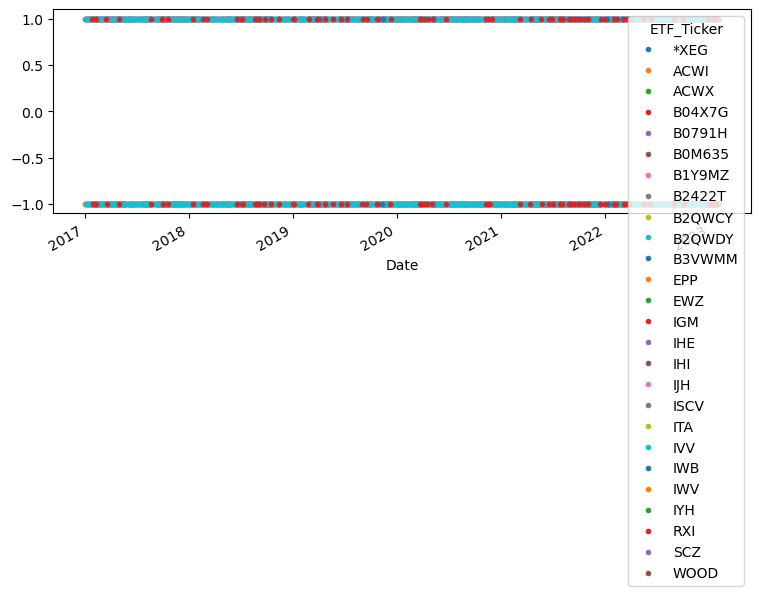

In [643]:
plot_df = trade_df.copy()
plot_df[plot_df == 0] = None
plot_df[plot_df > 0] = 1
plot_df[plot_df < 0] = -1
plot_df.plot(style='.', figsize=(9, 3))

In [697]:
linear_pred_df = pipeline.predict('linear', pairs,  params = {
                'pred_period': 'D',
                'cost' : 100
            })
trade_df, pair_trade_df = pipeline.create_signal('most_spread_rtn', linear_pred_df, params= {
                'holding_period': 1,
                'cost': 100
            })

<AxesSubplot:xlabel='Date'>

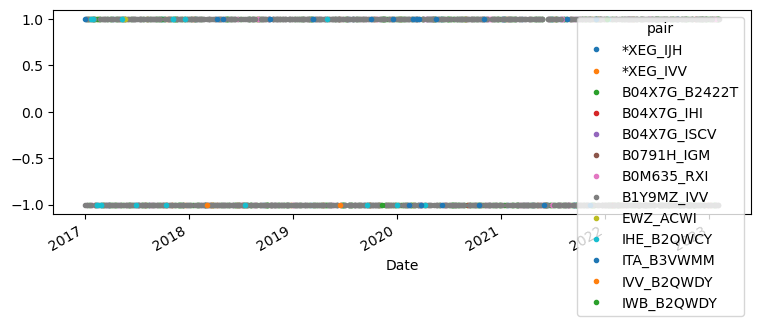

In [698]:
plot_df = pair_trade_df.pivot_table(values='side', columns='pair', index=pair_trade_df.index)
plot_df[plot_df == 0] = -1
plot_df.plot(style='.', figsize=(9, 3))

<AxesSubplot:xlabel='Date'>

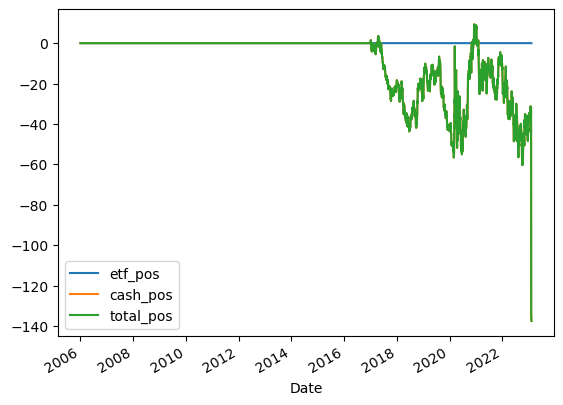

In [687]:
port_df = pipeline.generate_portfolio(trade_df)
port_df.plot()

<AxesSubplot:xlabel='Date'>

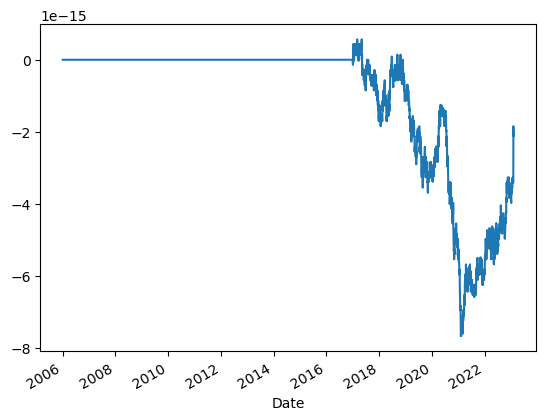

In [689]:
pipeline.calc_port_return(port_df, trade_df).plot()

<AxesSubplot:xlabel='Date'>

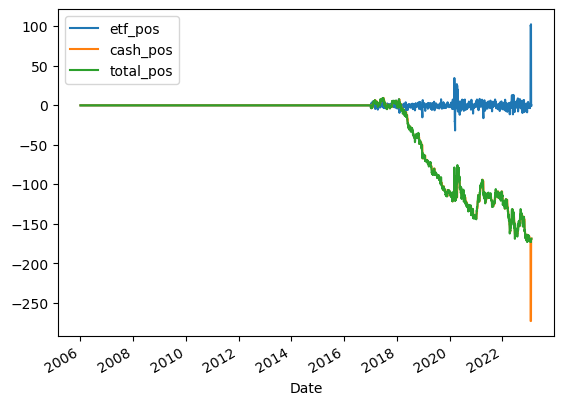

In [717]:
xgb_pred_df = pipeline.predict('XGB', pairs,  params = {
                'pred_period': 'W',
                'cost': 100.
            })
trade_df, pair_trade_df = pipeline.create_signal('most_spread_rtn', xgb_pred_df, params= {
                'holding_period': 5,
                'cost': 100.
            })
port_df = pipeline.generate_portfolio(trade_df)
port_df.plot()

<AxesSubplot:xlabel='Date'>

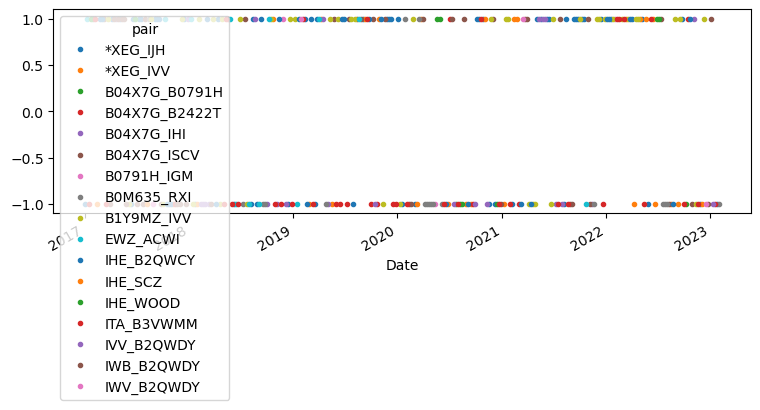

In [718]:
plot_df = pair_trade_df.pivot_table(values='side', columns='pair', index=pair_trade_df.index)
plot_df[plot_df == 0] = -1
plot_df.plot(style='.', figsize=(9, 3))

<AxesSubplot:xlabel='Date'>

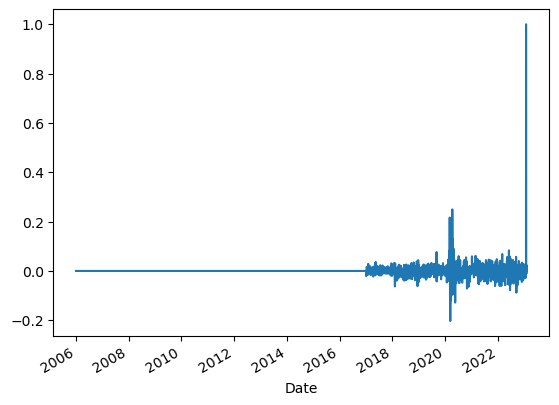

In [719]:
ret_df = pipeline.calc_port_return(port_df, trade_df)
ret_df.plot()

<AxesSubplot:xlabel='Date'>

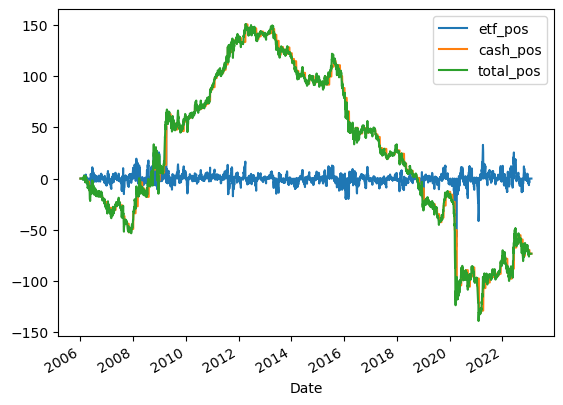

In [713]:
params = {
    'holding_period': 21,
    'distribution_period': 21,
    'training_ratio': 0.5,
    'cost': 100.
}
trade_df, pair_trade_df = pipeline.create_signal('percentile_current', linear_pred_df, params=params)
port_df = pipeline.generate_portfolio(trade_df)
port_df.plot()

<AxesSubplot:xlabel='Date'>

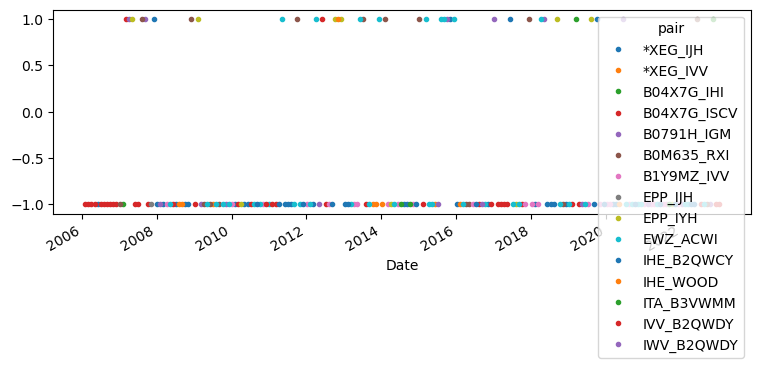

In [714]:
plot_df = pair_trade_df.pivot_table(values='side', columns='pair', index=pair_trade_df.index)
plot_df[plot_df == 0] = -1
plot_df.plot(style='.', figsize=(9, 3))

<AxesSubplot:xlabel='Date'>

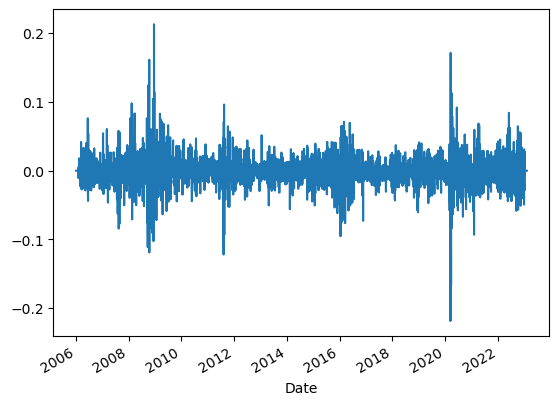

In [715]:
ret_df = pipeline.calc_port_return(port_df, trade_df)
ret_df.plot()